# GF Instruments correction
2020-05-23

GF Instruments use a custom linear calibration to convert the quadrature values measured by their instruments (e.g. CMD Explorer and CMD Mini-Explorer) into ECa. These calibrations can be supplied from the control unit as: 'F-Ground', 'F-0m' or 'F1-m'. It is essential to be aware of which calibration is being applied to the data as it has an important impact on the inversion of data collected with these instruments.
> NOTE: this notebook reflects the best of our knowledge on the GF Instruments calibration procedure. Please consult with the manufacturer for further details.

In [1]:
# import
import sys
sys.path.append('../src')
from emagpy.invertHelper import fMaxwellQ, getQs
from emagpy import Problem
import numpy as np
import matplotlib.pyplot as plt

## What is the purpose of the calibration?
The main advantage of these calibrations is that the ECa value obtained by the device is much closer to the ground EC than it would be if an ECa value obtained with the  LIN approximation is used (e.g. as is done by most other EMI manufacturers). The LIN equation ($ECa = \frac{4}{\omega \mu_0 s^2}Q$) is a simple multiplication of the Quadrature ($Q$) value. When the device is at 1 m above the ground the quadrature value measured would be smaller (due to the air layer) than when on the ground. This means that for the LIN derived ECa for the case where the device is at 1 m a smaller ECa value would be obtained in comparison to the ECa from the 'F-1m'.

## How the GF calibration works?
These calibrations equations are based on measurements made at a site with an assumed homogeneous conductivity of 50 mS/m. The quadrature values measured over 50 mS/m ($Q_{50}$) are used to compute a slope to directly convert the quadrature to ECa.

The calibration equation is
$$Q = a \times ECa$$

with 
$$ a = \frac{Q_{50}}{50}$$

Once established, the calibration equation can be rearranged to be used to predict ECa as a function of measured quadrature:
$$ ECa = \frac{Q}{a}$$

In [2]:
# synthetic simulation of GF calibration for the CMD Explorer F-1m calibration
cpos = ['vcp','vcp','vcp','hcp','hcp','hcp'] # coil orientation
cspacing = [1.48, 2.82, 4.49, 1.48, 2.82, 4.49] # coil separation [m]
hx = [1, 1, 1, 1, 1, 1] # height above the ground [m]
freq = 10000 # Hz
depths = np.array([5])
Q50 = np.imag(getQs(np.ones(2)*50, depths, cspacing, cpos, freq, hx=hx))*1000 # [ppt]
print(Q50)

[ 0.64177379  3.56440701 10.94089298  1.14377679  5.42102767 14.2368228 ]


inverted slopes: [77.90907085 14.02757873  4.57001088 43.714823    9.22334343  3.51201955]


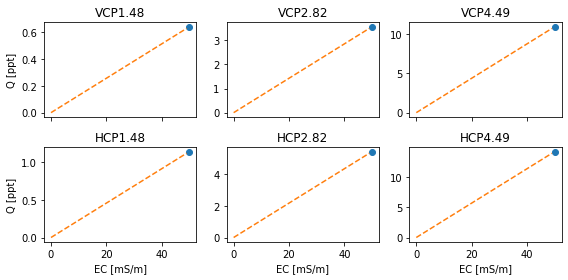

In [3]:
slope = Q50/50
print('inverted slopes:', 1/slope)

fig, axs = plt.subplots(2, 3, sharex=True, figsize=(8,4))
axs = axs.flatten()
for i in range(len(cpos)):
    ax = axs[i]
    ax.set_title('{:s}{:.2f}'.format(cpos[i].upper(), cspacing[i]))
    ax.plot(50, Q50[i], 'o')
    ax.plot(np.arange(50), slope[i] * np.arange(50), '--')
    if i > 2:
        ax.set_xlabel('EC [mS/m]')
    if i % 3 == 0:
        ax.set_ylabel('Q [ppt]')
fig.tight_layout()

## Impact on the inversion
The GF calibrations add a non physically-based transformation on the ECa that cannot be modelled easily. By neglecting the contribution of the air layer between the instrument and the ground, the GF calibration obtains larger ECa values (closer to the ground EC) but not representative of the signal received.

One could argue that one way to avoid that is simply to invert ECa values  obtained with the 'F-1m' calibration such as if they were taken directly on the ground (i.e. h = 0 m). However, such an approach neglects the differences in the shapes of the sensitivity functions between a device at 0 m and at 1 m above the ground. The sensitivity patterns are **not the same** and this can impact the inversion.

gfCorrection: F-1m calibrated ECa converted to LIN ECa
Survey 1/1
21/21 inverted
Survey 1/1
21/21 inverted
Survey 1/1
21/21 inverted


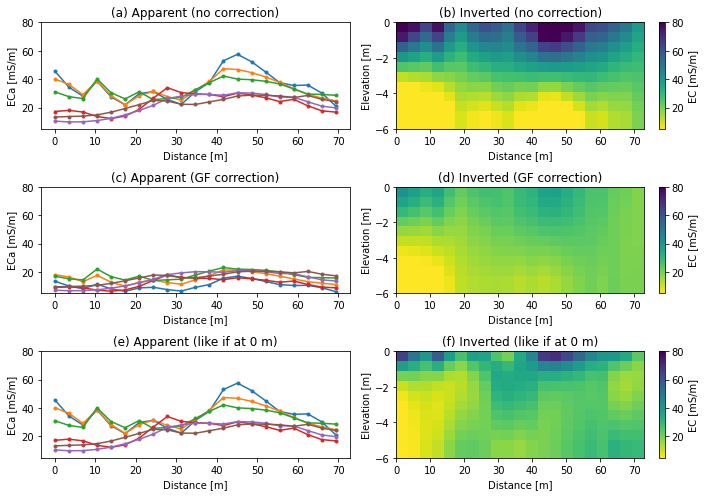

In [4]:
# no correction
k1 = Problem()
k1.createSurvey('../src/examples/hollin-hill/expl-transect.csv')

# with GF correction
k2 = Problem()
k2.createSurvey('../src/examples/hollin-hill/expl-transect.csv')
k2.gfCorrection(calib='F-1m')

# like if it was collected at 0 m
k3 = Problem()
k3.createSurvey('../src/examples/hollin-hill/expl-transect.csv')
k3.hx = np.zeros(6) # make it like data were collected at 0 m

ks = [k1, k2, k3]
for k in ks:
    k.setInit(depths0=np.linspace(0.01, 5, 10))
    k.invert(forwardModel='CS', method='Gauss-Newton')
    
# figure
fig, axs = plt.subplots(len(ks), 2, figsize=(10,7))
letters = ['a','b','c','d','e','f']
labs = ['no correction', 'GF correction', 'like if at 0 m']
for i, k in enumerate(ks):
    k.show(ax=axs[i,0], vmin=5, vmax=80)
    axs[i,0].get_legend().remove()
    axs[i,0].set_title('({:s}) Apparent ({:s})'.format(letters[i*2], labs[i]))
    k.showResults(ax=axs[i,1], vmin=5, vmax=80)
    axs[i,1].set_title('({:s}) Inverted ({:s})'.format(letters[i*2+1], labs[i]))

### Observations:
- when quadrature values are transformed to LIN ECa values (c), the ECa values are smaller as they take into account the air layer (0 mS/m) between the instrument and the ground.
- inverting EC without correcting for the GF calibration shows larger amplitude in inverted EC values (i.e. the model conductivities are artificially elevated).
- inverting data 'like if at 0 m' (i.e. wrongly assuming the data were collected on the ground) provides a range of inverted EC (f) much closer to 'GF corrected' inverted EC (d) however their distribution is not the same as the sensitivity patterns are incorrect. Hence, the sensitivity is artificially increased closer to the surface which  leads to higher EC values.

2/30 data removed (filterRange).
2/30 data removed (filterRange).
gfCorrection: F-0m calibrated ECa converted to LIN ECa
Survey 1/1
28/28 inverted
Survey 1/1
28/28 inverted


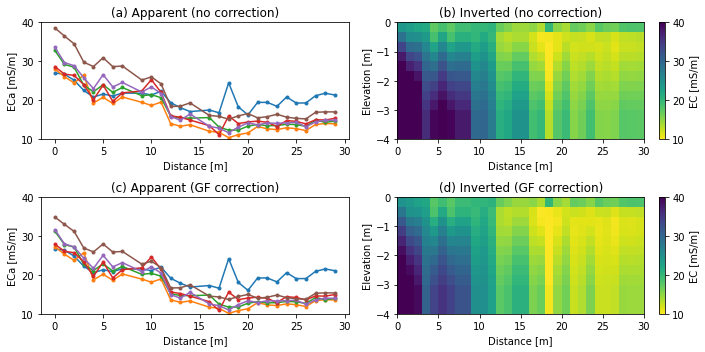

In [5]:
# no correction
k1 = Problem()
k1.createSurvey('../src/examples/cover-crop/coverCropTransect.csv')
k1.filterRange(vmax=40)

# with correction
k2 = Problem()
k2.createSurvey('../src/examples/cover-crop/coverCropTransect.csv')
k2.filterRange(vmax=40)
k2.gfCorrection(calib='F-0m')

ks = [k1, k2]
for k in ks:
    k.setInit(depths0=np.linspace(0.01, 3, 10))
    k.invert(forwardModel='CS', method='Gauss-Newton')
    
# figure
fig, axs = plt.subplots(len(ks), 2, figsize=(10,5))
letters = ['a','b','c','d','e','f']
labs = ['no correction', 'GF correction', 'like if at 0 m']
for i, k in enumerate(ks):
    k.show(ax=axs[i,0], vmin=10, vmax=40)
    axs[i,0].get_legend().remove()
    axs[i,0].set_title('({:s}) Apparent ({:s})'.format(letters[i*2], labs[i]))
    k.showResults(ax=axs[i,1], vmin=10, vmax=40)
    axs[i,1].set_title('({:s}) Inverted ({:s})'.format(letters[i*2+1], labs[i]))

## Conclusions
- It is important to be aware of which calibration has been used and what was the height of the instrument when data were collected
- **If data are collected at 1 m above the ground, it is important to convert the calibrated ECa to a LIN ECa using `gfCorrection(calib='F-1m')`. This has important impact on the inversion.**
- Inverting 'F-1m' ECa data as if they were taken at 0 m will likely lead to wrong inversion results due to the different sensitivity pattern if the device is at 0 m or at 1 m. It is hence not recommended.
> Note: we do not recommend using the 'F-0m' or 'F-Ground' calibration to collect data at 1 m above the ground as this will reduce the precision of the ECa values collected. We rather recommend to transform them after.
- If the data were collected on the ground, the GF correction can still be applied but it's impact on the inversion will be smaller.
- EMI inversion always have some uncertainty due to the small number of coils compared to the number of parameters. However, we found out that not applying this GF correction when collecting data with 'F-1m' lead to substantial distortion of the inverse results, greater than the 'normal' uncertainty of the inversion.